In [1]:
# Import Modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#modeling tools
import statsmodels.api as sm

import lightgbm as lgb

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, auc, roc_auc_score, roc_curve, log_loss, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

%matplotlib inline
plt.style.use('dark_background')

%load_ext autoreload
%autoreload 2

# pd.set_option('display.min_row', 25)
pd.set_option('display.max_column', 100)
pd.set_option('display.max_colwidth', 300)

In [131]:
blocks = pd.read_csv('../data/processed/blocks_sev_score.csv', index_col=0)
intersections = pd.read_csv('../data/processed/intersections_sev_score.csv', index_col=0)
circles = pd.read_csv('../data/processed/circles_sev_score.csv', index_col=0)
crosswalks = pd.read_csv('../data/processed/crosswalks_sev_score.csv', index_col=0)

## Blocks

In [132]:
blocks.head()

,location,artdescript,speedlimit,segdir,oneway,surfacetype_1,nationhwysys,streettype,tranclass,trandescript,slope_pct,parkboulevard,year,count,total fatalities,total serious injuries,total evident injuries,total possible injuries,total vehicles,total pedestrians involved,total bicyclists involved,weigh_fatalities,weigh_serious,weigh_evident,weigh_possible,sev_score
0,1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST,Minor Arterial,25.0,NW,N,PCC,N,Downtown Neighborhood,1,PRINCIPAL TRANSIT ROUTE,4.0,N,2004.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004
1,1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST,Minor Arterial,25.0,NW,N,PCC,N,Downtown Neighborhood,1,PRINCIPAL TRANSIT ROUTE,4.0,N,2005.0,2.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.000018
2,1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST,Minor Arterial,25.0,NW,N,PCC,N,Downtown Neighborhood,1,PRINCIPAL TRANSIT ROUTE,4.0,N,2006.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000013
3,1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST,Minor Arterial,25.0,NW,N,PCC,N,Downtown Neighborhood,1,PRINCIPAL TRANSIT ROUTE,4.0,N,2007.0,4.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000018
4,1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST,Minor Arterial,25.0,NW,N,PCC,N,Downtown Neighborhood,1,PRINCIPAL TRANSIT ROUTE,4.0,N,2008.0,3.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000013


In [133]:
# check datatype
blocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87248 entries, 0 to 87247
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   location                    87248 non-null  object 
 1   artdescript                 87248 non-null  object 
 2   speedlimit                  87248 non-null  float64
 3   segdir                      87248 non-null  object 
 4   oneway                      87248 non-null  object 
 5   surfacetype_1               87248 non-null  object 
 6   nationhwysys                87248 non-null  object 
 7   streettype                  87248 non-null  object 
 8   tranclass                   87248 non-null  int64  
 9   trandescript                87248 non-null  object 
 10  slope_pct                   87248 non-null  float64
 11  parkboulevard               87248 non-null  object 
 12  year                        87248 non-null  float64
 13  count                       872

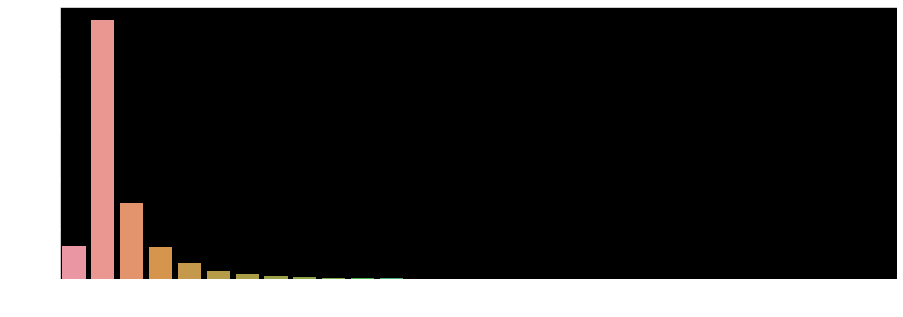

In [134]:
fig, ax = plt.subplots(figsize=(15,5))

sns.countplot(blocks['count']);

In [228]:
blocks.columns

Index(['location', 'artdescript', 'speedlimit', 'segdir', 'oneway',
       'surfacetype_1', 'nationhwysys', 'streettype', 'tranclass',
       'trandescript', 'slope_pct', 'parkboulevard', 'year', 'count',
       'total fatalities', 'total serious injuries', 'total evident injuries',
       'total possible injuries', 'total vehicles',
       'total pedestrians involved', 'total bicyclists involved',
       'weigh_fatalities', 'weigh_serious', 'weigh_evident', 'weigh_possible',
       'sev_score'],
      dtype='object')

In [232]:
blocks = blocks.groupby(['location', 'artdescript', 'speedlimit', 'segdir', 'oneway',
       'surfacetype_1', 'nationhwysys', 'streettype', 'tranclass',
       'trandescript', 'slope_pct', 'parkboulevard']).sum().drop(columns='year').reset_index()

In [233]:
b_top10 = blocks.sort_values(by='count', ascending=False)[:10]

In [234]:
b_lowest = blocks.sort_values(by='count')[:10]

The top 10 blocks with the most count of collisions are all Principal Arterials

In [235]:
b_lowest['slope_pct'].mean()

3.8

In [236]:
b_top10['slope_pct'].mean()

1.4

In [237]:
b_lowest['slope_pct'].mean()

3.8

In [238]:
print(b_top10['location'])

13788                                N NORTHGATE WAY BETWEEN MERIDIAN AVE N AND CORLISS AVE N
8034                                           AURORA AVE N BETWEEN N 117TH PL AND N 125TH ST
8038                                           AURORA AVE N BETWEEN N 130TH ST AND N 135TH ST
17427                                   RAINIER AVE S BETWEEN S BAYVIEW ST AND S MCCLELLAN ST
23294    WEST SEATTLE BR EB BETWEEN ALASKAN WY VI NB ON RP AND DELRIDGE-W SEATTLE BR EB ON RP
8105                                               AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N
1505                                                 1ST AVE BETWEEN BLANCHARD ST AND BELL ST
17460                                RAINIER AVE S BETWEEN S HENDERSON ST AND S DIRECTOR N ST
15731                                      NE NORTHGATE WAY BETWEEN 3RD AVE NE AND 5TH AVE NE
17433                                 RAINIER AVE S BETWEEN S CHARLESTOWN ST AND S ANDOVER ST
Name: location, dtype: object


In [243]:
b_top10.columns

Index(['location', 'artdescript', 'speedlimit', 'segdir', 'oneway',
       'surfacetype_1', 'nationhwysys', 'streettype', 'tranclass',
       'trandescript', 'slope_pct', 'parkboulevard', 'count',
       'total fatalities', 'total serious injuries', 'total evident injuries',
       'total possible injuries', 'total vehicles',
       'total pedestrians involved', 'total bicyclists involved',
       'weigh_fatalities', 'weigh_serious', 'weigh_evident', 'weigh_possible',
       'sev_score'],
      dtype='object')

In [244]:
blocks['collisions'] = (blocks['sev_score'] > 0).astype(int)

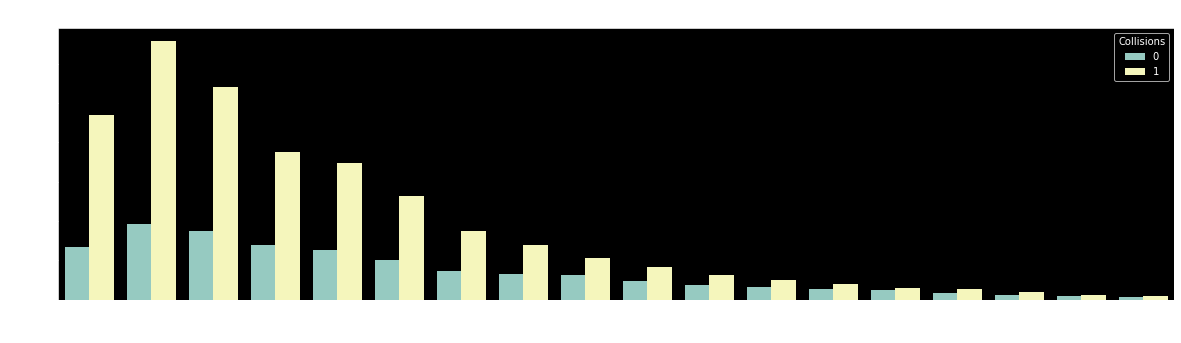

In [274]:
fig, ax = plt.subplots(figsize=(20,5))

sns.countplot(blocks[blocks['slope_pct'] < 18]['slope_pct'], hue=blocks['collisions'])
ax.set_title('Blocks: Collision Slope vs Non-collision Slope',  fontsize=20);
ax.set_ylabel('Number of Blocks', fontsize=15)
ax.set_xlabel('Slope Percentage',  fontsize=15)
ax.legend(labels=[0,1], title='Collisions', fontsize=10)

plt.savefig('../reports/figures/blocks_slope.png')

In [137]:
b_top10_sev = blocks.sort_values(by='sev_score', ascending=False)[:10]

In [138]:
b_top10_sev.head(2)

,location,artdescript,speedlimit,segdir,oneway,surfacetype_1,nationhwysys,streettype,tranclass,trandescript,slope_pct,parkboulevard,year,count,total fatalities,total serious injuries,total evident injuries,total possible injuries,total vehicles,total pedestrians involved,total bicyclists involved,weigh_fatalities,weigh_serious,weigh_evident,weigh_possible,sev_score
46276,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,Principal Arterial,40.0,N,N,AC/PCC,N,Urban Village Main,2,MAJOR TRANSIT ROUTE,2.0,N,2015.0,23.0,5.0,41.0,27.0,30.0,51.0,0.0,0.0,25.0,164.0,81.0,60.0,0.001552
32884,HIGHLAND PARK WAY SW BETWEEN WEST MARGINAL WAY SW AND SW OTHELLO ST,Principal Arterial,25.0,W,N,AC/PCC,N,Neighborhood Corridor,3,MINOR TRANSIT ROUTE,11.0,N,2005.0,18.0,0.0,2.0,6.0,13.0,30.0,1.0,0.0,0.0,8.0,18.0,26.0,0.000308


In [139]:
# about 93% of blocks have had a collision over the 16 year period

(blocks['year'] != 0).sum() / len(blocks['year'])

0.9254653401797176

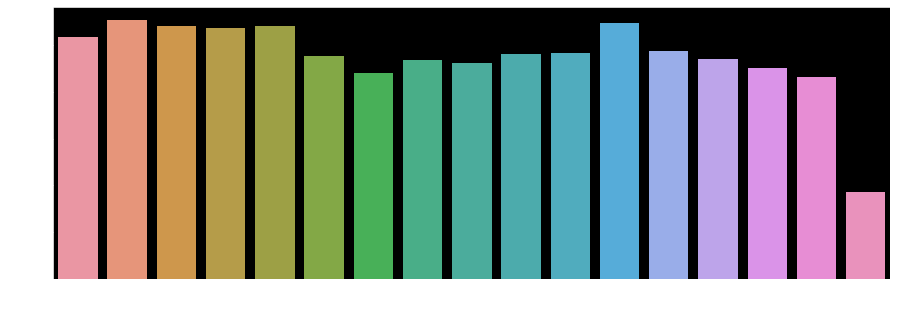

In [140]:
fig, ax = plt.subplots(figsize=(15,5))

sns.countplot(blocks[blocks['year'] != 0]['year']);

#### Remove time

In [141]:
b_notime = blocks.drop(columns='year').copy()

In [152]:
b_notime.head()

,location,artdescript,speedlimit,segdir,oneway,surfacetype_1,nationhwysys,streettype,tranclass,trandescript,slope_pct,parkboulevard,count,total fatalities,total serious injuries,total evident injuries,total possible injuries,total vehicles,total pedestrians involved,total bicyclists involved,weigh_fatalities,weigh_serious,weigh_evident,weigh_possible,sev_score
0,1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST,Minor Arterial,25.0,NW,N,PCC,N,Downtown Neighborhood,1,PRINCIPAL TRANSIT ROUTE,4.0,N,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004
1,1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST,Minor Arterial,25.0,NW,N,PCC,N,Downtown Neighborhood,1,PRINCIPAL TRANSIT ROUTE,4.0,N,2.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.000018
2,1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST,Minor Arterial,25.0,NW,N,PCC,N,Downtown Neighborhood,1,PRINCIPAL TRANSIT ROUTE,4.0,N,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000013
3,1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST,Minor Arterial,25.0,NW,N,PCC,N,Downtown Neighborhood,1,PRINCIPAL TRANSIT ROUTE,4.0,N,4.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000018
4,1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST,Minor Arterial,25.0,NW,N,PCC,N,Downtown Neighborhood,1,PRINCIPAL TRANSIT ROUTE,4.0,N,3.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000013


## Blocks with and without collisions

In [101]:
b_nocol = blocks[blocks['sev_score'] == 0].drop(columns='year').groupby(['location', 'speedlimit', 'slope_pct', 'tranclass']).sum().reset_index()
b_yescol = blocks[blocks['sev_score'] != 0].drop(columns='year').groupby(['location', 'speedlimit', 'slope_pct', 'tranclass']).sum().reset_index()

#### No Collision Blocks

In [108]:
b_nocol.describe()

,speedlimit,slope_pct,tranclass,count,total fatalities,total serious injuries,total evident injuries,total possible injuries,total vehicles,total pedestrians involved,total bicyclists involved,weigh_fatalities,weigh_serious,weigh_evident,weigh_possible,sev_score
count,6503.000000,6503.000000,6503.000000,6503.0,6503.0,6503.0,6503.0,6503.0,6503.0,6503.0,6503.0,6503.0,6503.0,6503.0,6503.0,6503.0
mean,21.166385,4.794249,0.171459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,5.093376,4.373741,0.721407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,20.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,20.000000,4.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,20.000000,7.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,60.000000,47.000000,6.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
print('Average speedlimit for blocks with no incidents: ', b_nocol['speedlimit'].mean())
print('Average slope percent for blocks with no incidents: ', b_nocol['slope_pct'].mean())

Average speedlimit for blocks with no incidents:  21.166384745502075
Average slope percent for blocks with no incidents:  4.79424880824235


#### Collision Blocks

In [166]:
print('Average speedlimit for blocks with incidents: ', b_yescol['speedlimit'].mean())
print('Average slope percent for blocks with incidents: ', b_yescol['slope_pct'].mean())

Average speedlimit for blocks with incidents:  22.85084131806497
Average slope percent for blocks with incidents:  3.661836877775181


In [109]:
b_yescol.describe()

,speedlimit,slope_pct,tranclass,count,total fatalities,total serious injuries,total evident injuries,total possible injuries,total vehicles,total pedestrians involved,total bicyclists involved,weigh_fatalities,weigh_serious,weigh_evident,weigh_possible,sev_score
count,17116.000000,17116.000000,17116.000000,17116.000000,17116.000000,17116.000000,17116.000000,17116.000000,17116.000000,17116.000000,17116.000000,17116.000000,17116.000000,17116.000000,17116.000000,17116.000000
mean,22.850841,3.661837,0.747897,8.292767,0.010224,0.091961,0.482473,1.565845,11.881047,0.134377,0.129002,0.051122,0.367843,1.447418,3.131690,0.000058
std,4.765725,3.538022,1.231706,14.233096,0.126346,0.525664,1.396246,4.609931,21.765155,0.539794,0.580286,0.631728,2.102654,4.188738,9.219862,0.000120
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000004
25%,20.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000009
50%,20.000000,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000018
75%,25.000000,5.000000,2.000000,8.000000,0.000000,0.000000,0.000000,1.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000053
max,60.000000,32.000000,6.000000,296.000000,5.000000,44.000000,46.000000,141.000000,459.000000,12.000000,20.000000,25.000000,176.000000,138.000000,282.000000,0.003191


#### Plot both

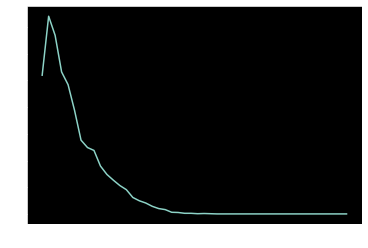

In [199]:
((b_nocol['slope_pct'].value_counts() / len(b_nocol['slope_pct'])*100).sort_index()).plot(kind='line')

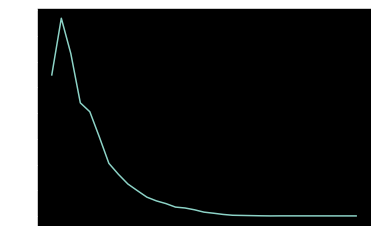

In [200]:
((b_yescol['slope_pct'].value_counts() / len(b_yescol['slope_pct'])*100).sort_index()).plot(kind='line')

In [202]:
(b_yescol['slope_pct'].value_counts() / len(b_yescol['slope_pct'])*100).sort_index()

0.0     13.712316
1.0     19.221781
2.0     15.786399
3.0     10.995560
4.0     10.130872
5.0      7.677027
6.0      5.118018
7.0      4.054686
8.0      3.108203
9.0      2.459687
10.0     1.828698
11.0     1.466464
12.0     1.203552
13.0     0.864688
14.0     0.777051
15.0     0.601776
16.0     0.373919
17.0     0.268754
18.0     0.151905
19.0     0.070110
20.0     0.052582
21.0     0.035055
22.0     0.017527
23.0     0.005842
24.0     0.011685
32.0     0.005842
Name: slope_pct, dtype: float64

In [170]:
b_yescol['slope_pct'].mean()

3.661836877775181

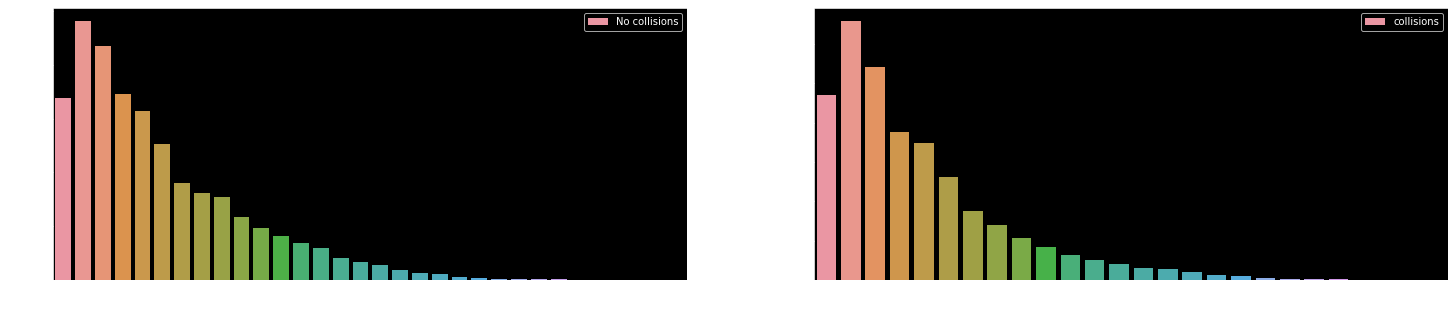

In [164]:
fig, axes = plt.subplots(1,2,figsize=(25,5))

sns.countplot(b_nocol['slope_pct'], ax=axes[0], label='No collisions');
sns.countplot(b_yescol['slope_pct'], ax=axes[1], label='collisions');
axes[0].legend();
axes[1].legend();

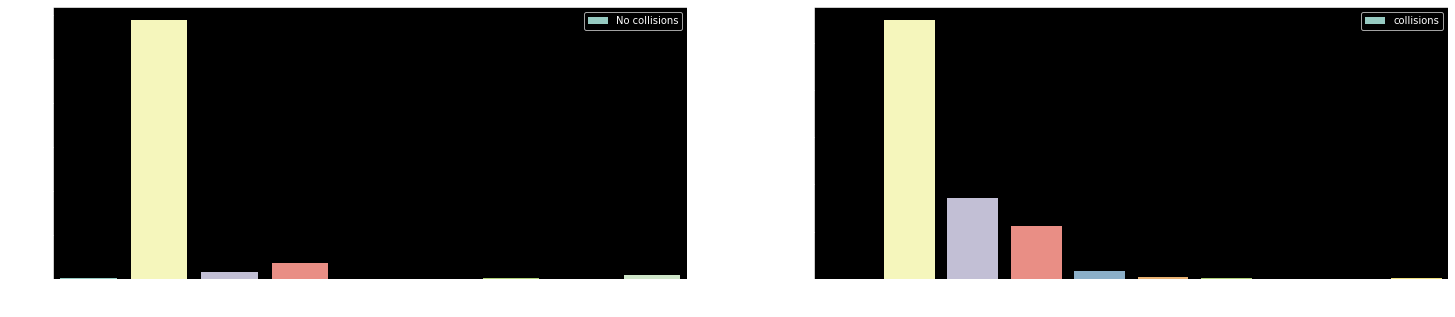

In [161]:
fig, axes = plt.subplots(1,2,figsize=(25,5))

sns.countplot(b_nocol['speedlimit'], ax=axes[0], label='No collisions');
sns.countplot(b_yescol['speedlimit'], ax=axes[1], label='collisions');
axes[0].legend();
axes[1].legend();

## Intersections

In [40]:
# about 84% of intersections have had a collision over the 16 year period

(intersections['year'] != 0).sum() / len(intersections['year'])

0.8363013698630137

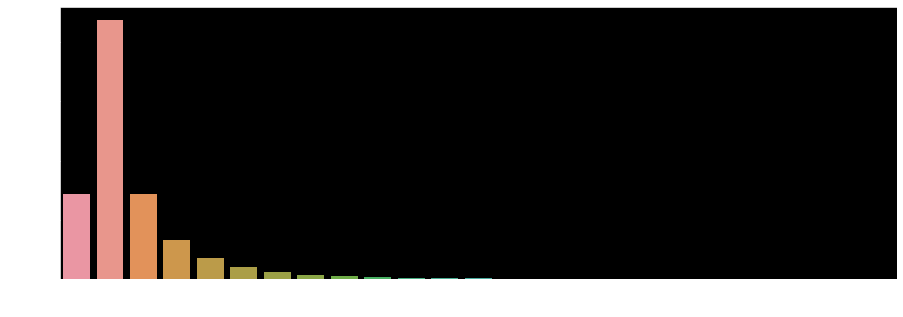

In [33]:
fig, ax = plt.subplots(figsize=(15,5))

sns.countplot(intersections['count']);

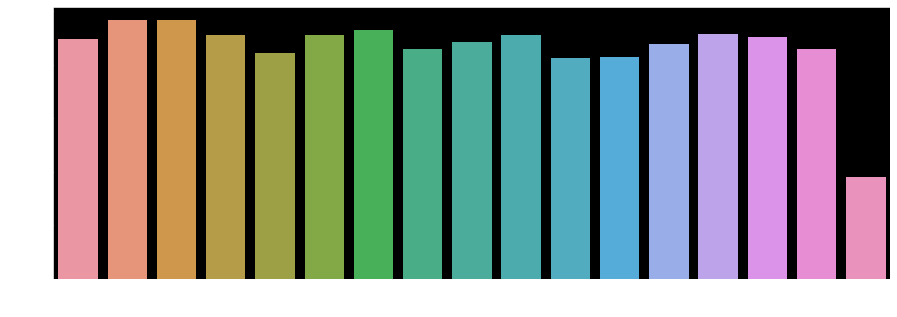

In [39]:
fig, ax = plt.subplots(figsize=(15,5))

sns.countplot(intersections[intersections['year'] != 0]['year']);

## Circles

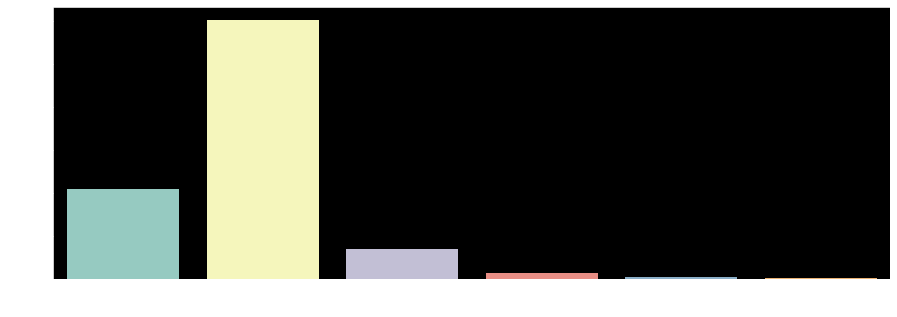

In [31]:
fig, ax = plt.subplots(figsize=(15,5))

sns.countplot(circles['count']);

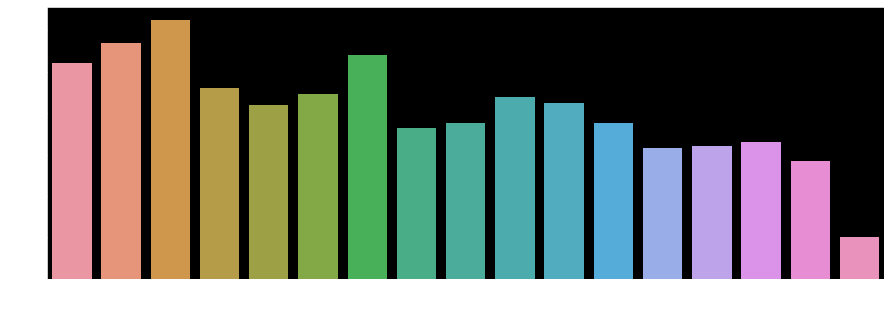

In [32]:
fig, ax = plt.subplots(figsize=(15,5))

sns.countplot(circles[circles['year'] != 0]['year']);

In [42]:
# about 77% of circles have had a collision over the 16 year period

(circles['year'] != 0).sum() / len(circles['year'])

0.7686318131256952

## Crosswalks